### Outline

0. Load Data and Restore results
<br />
<br />
1. Stabilization for linear transformations
<br />
<br />
2. 

SpaGFT is a python package to analyze spatial transcriptomics data via graph Fourier transform. To install SpaGFT, the python version is required to be >= 3.7. You can check your python version by:

In [1]:
import platform
platform.python_version()

'3.10.19'

In [ ]:
# Import stages
from stage_0_setup import stage_0_main as s0
from stage_1_lin_trns import stage_1_main as s1

# Another imports
from contextlib import redirect_stdout
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Stage 0：Load Data and Restore results


During this step we will clone/load data, transform it to anndata object and run local SpaGFT to get SVG list. Then compare top-100 SVG list output with the SVG atlas at https://huggingface.co/spaces/jiawennnn/STimage-benchmark. We will measure the consistency by the Jaccard Index between those SVG lists.

This process is being done for 4 slides tested in the arxiv paper at https://arxiv.org/html/2510.07653v1#S12. 

### Run

In [3]:
tissue_dict = {
    'Human_Breast_Andersson_10142021_ST_A1': {'name': 'Human Breast Andersson', 'tech': 'ST'},
    'Human_Brain_Maynard_02082021_Visium_151676': {'name': 'Human Brain Maynard', 'tech': 'Visium'},
    'Human_Breast_10X_06092021_Visium': {'name': 'Human Breast 10X', 'tech': 'Visium'},
    'GSE213688_GSM6592060': {'name': 'GSE213688_GSM6592060', 'tech': 'Visium'}
}

In [ ]:
# Initialization
stage_0_results_list = []

# Loop over tissues
for slide_id, slide_param in tissue_dict.items():    
    # Clone/Load data, run SpaGFT and compare top-100 SVG list with the SVG atlas
    slide_metrics = s0.run_stage_0_pipeline(
        slide_id=slide_id, tech=slide_param['tech'],
        restrict_logs=True
    )['metrics']
    stage_0_results_list.append({
        'tissue': slide_param['name'], 'tech': slide_param['tech'], 
        'SpaGFT local VS atlas (jaccard)': slide_metrics['SpaGFT']['jaccard_ref'],
        'MoranI local VS atlas (jaccard)': slide_metrics['MoranI']['jaccard_ref'],
        'SpaGFT local VS gt (jaccard)': slide_metrics['SpaGFT']['jaccard_gt'],
        'MoranI local VS gt (jaccard)': slide_metrics['MoranI']['jaccard_gt'],
    })

slide_metrics = []

### Result Tables

In [7]:
# Show jaccard index for successfull restoring the atlas results
pd.DataFrame(stage_0_results_list)

,tissue,tech,SpaGFT local VS atlas (jaccard),MoranI local VS atlas (jaccard),SpaGFT local VS gt (jaccard),MoranI local VS gt (jaccard)
0,Human Breast Andersson,ST,0.785714,0.408451,0.438849,0.503759
1,Human Brain Maynard,Visium,0.923077,0.069519,0.324503,0.041667
2,Human Breast 10X,Visium,0.960784,0.123596,0.369863,0.190476
3,GSE213688_GSM6592060,Visium,0.818182,0.098901,0.212121,0.197605


## Stage 1：Stability Check
Examine the Stability for linear transformations by 8 different transformation scenarios

### Run

In [8]:
# Add tissues from ExSeq technology
tissue_dict['fem4_WT_F11'] = {'name': 'Mouse Brain WT fem4', 'tech': 'exseq'}
tissue_dict['fem3_5x_E7_A_left'] = {'name': 'Mouse Brain 5x fem3', 'tech': 'exseq'}

In [9]:
stage_1_results = {}
# Loop over tissues
for slide_id, slide_param in tissue_dict.items():
    # Run stability test for the default scenarios
    stage_1_results[slide_param['name']] = s1.run_stability_test(
        slide_id=slide_id, tech=slide_param['tech'], 
        save_results=True, restrict_logs=True
    )

### Plot Stability Boxplot

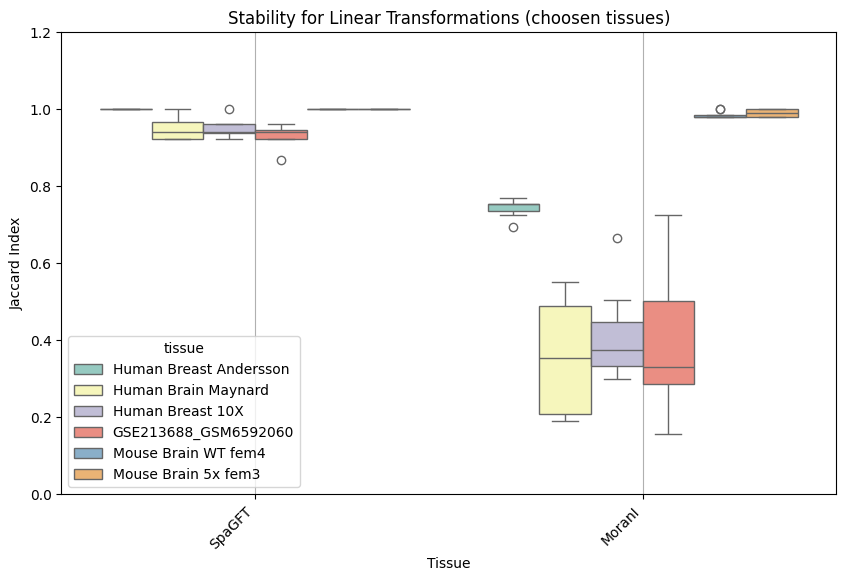

In [10]:
# For each tissue, show the distribution of Jaccard index across tissues
jaccard_records = []
for tissue, results in stage_1_results.items():
    for row in results.itertuples():
        jaccard_records.append({
            'tissue': tissue,
            'transformation': row.name,
            'method': row.method,
            'Jaccard': row.Jaccard
        })
jaccard_records_df = pd.DataFrame(jaccard_records)

# Plotting the Jaccard index distributions
plt.figure(figsize=(10, 6))
sns.boxplot(x = 'method', y='Jaccard', hue='tissue', data=jaccard_records_df, palette="Set3")
plt.ylim(0, 1.2)
plt.title('Stability for Linear Transformations (choosen tissues)')
plt.xlabel('Tissue')
plt.ylabel('Jaccard Index')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x')

plt.show()

### Test random state effect

In [11]:
scenarios = []
# Define all scenarios as baseline and compare them by the stability test
for i in range(4):
    scenarios.append({'name': f'scenario {i+1}', 'angle': 0, 'scaling': 1, 'translation': 0, 'flip': False})
no_transformation_results = s1.run_stability_test(slide_id='Human_Breast_Andersson_10142021_ST_A1',
                     tech='Visium',
                     methods_to_test="MoranI",
                     scenarios=scenarios,
                     save_results=False,
                     restrict_logs=True
                     )

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62/s]


In [12]:
no_transformation_results

,name,angle,scaling,translation,flip,method,Jaccard,Spearman,Overlap
0,scenario 1,0,1,0,False,MoranI,0.724138,0.977070,84
1,scenario 2,0,1,0,False,MoranI,0.694915,0.976842,82
2,scenario 3,0,1,0,False,MoranI,0.709402,0.976615,83
3,scenario 4,0,1,0,False,MoranI,0.666667,0.977226,80


In [13]:
scenarios = []
# Define all scenarios as baseline and compare them by the stability test
for i in range(4):
    scenarios.append({'name': f'scenario {i+1}', 'angle': 0, 'scaling': 1.0, 'translation': 0, 'flip': False})
no_transformation_results = s1.run_stability_test(slide_id='GSE213688_GSM6592060',
                     tech='Visium',
                     methods_to_test="SpaGFT",
                     scenarios=scenarios,
                     save_results=False,
                     restrict_logs=True
                     )

In [14]:
no_transformation_results

,name,angle,scaling,translation,flip,method,Jaccard,Spearman,Overlap
0,scenario 1,0,1.0,0,False,SpaGFT,0.980198,0.998046,99
1,scenario 2,0,1.0,0,False,SpaGFT,0.960784,0.998427,98
2,scenario 3,0,1.0,0,False,SpaGFT,0.980198,0.998457,99
3,scenario 4,0,1.0,0,False,SpaGFT,0.980198,0.997754,99


## Stage 2：Stability Improvement by Changing Graph Type
Benchmark Stability results under changing the graph representation of tissues before running SpaGFT